###MATH 5453M FEM Numerical Exercise 3, 2025     
*Katie Tutty*

##4) Solve the system in Firedrake

In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-12-23 19:29:21--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-12-23 19:29:21 (41.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ff61

## 4.  i) Plotting different meshes


In [2]:
#
# Solution by Firedrake FEM-CG of a Poisson equatiom
#
from firedrake import *




nx = ny = 256 # Try various mesh resolutions, starting coarse, say 16x16 etc.

mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
# Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
# Alternatively use gmsh:

V = FunctionSpace(mesh, 'CG', 1) # Piecewise linear continuous Galerkin function space or polynomials
# See: https://www.firedrakeproject.org/variational-problems.html

#
# Method 1: construct the weak form manually by multiplying and manipulating the Poisson equation and solve the linear system
#
u = TrialFunction(V) # The unknown or variable u(x,y)
v = TestFunction(V)  # The testfunction of u, which may be better called delu or deltau

x, y = SpatialCoordinate(mesh) # Mesh coordinates

f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)

a = (inner(grad(u),grad(v)))*dx # Step 2/3: The weak form first term
L = (f*v)*dx # Step 2/3: The weak form second term; dx is the infinitesimal piece in the damain here: dx*dy=dA with area A.

u_1 = Function(V, name='u_1') # Name of solution for first method

bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed
bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed
# See: https://www.firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC
# The homogeneous Neumann boundary conditions are "automatically" included, i.e. do not need anything explicit

solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0,bc_x1]) # Step 4: the solution assigned to u1

#
# Method 2: generate the weak form via "derivative()" of the Ritz-Galerkin integral or variational principle and solve the nonlinear system
#
u_2 = Function(V, name='u_2') # Name of solution for first method

Ju = (0.5*inner(grad(u_2),grad(u_2)) - u_2*f)*dx # f->ULF? Step 2

F = derivative(Ju, u_2, du=v) # Step 2/3: The weak form generated

solve(F == 0, u_2, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2

#
# Post-processing: Use Paraview to visualise
# See https://www.firedrakeproject.org/visualisation.html#creating-output-files
outfile = VTKFile('output.pvd')
outfile.write(u_1, u_2)

f.interpolate(sin(pi*x)*cos(pi*y))
L2_1 = sqrt(assemble(dot(u_1 - f, u_1 - f) * dx)) # L2 error solution u1
L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx)) # L2 error solution u2
L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx)) # L2 error difference
print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
print(f'L2 norm between the two results: {L2}')




Mesh resolution: Δx = 0.00390625
L2 error: Method1 = 6.274721111753363e-06, Method2 = 6.274721471622985e-06
L2 norm between the two results: 3.599468214418768e-13


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_1_contour.png


KeyboardInterrupt: 

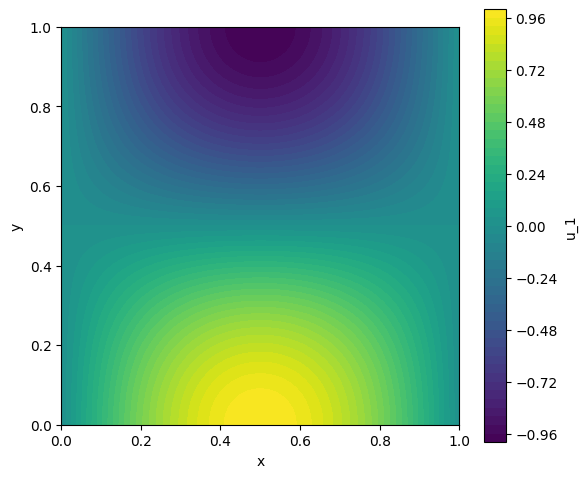

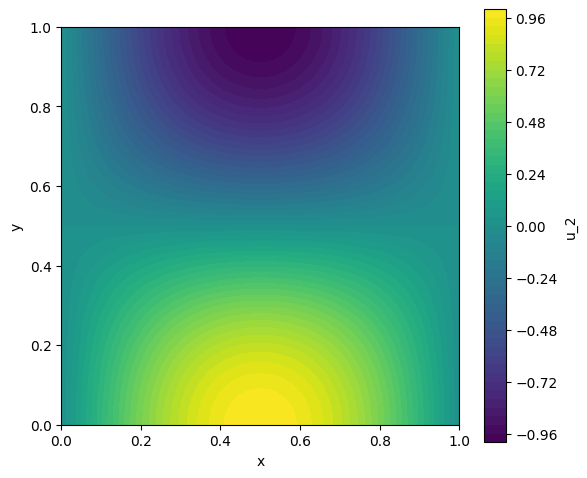

In [4]:
import matplotlib.pyplot as plt

def contour_plot(x, y, f, name):
    # Create grid
    x = np.linspace(0.0, 1.0, nx)
    y = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Evaluate f on grid using Firedrake's f.at()
    for j in range(len(y)):
        for i in range(len(x)):
            xv = X[j, i]
            yv = Y[j, i]
            Z[j, i] = f.at([xv, yv], tolerance=1e-10)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    cbar = fig.colorbar(cs, ax=ax)
    cbar.set_label(name)

    fig.tight_layout()
    fig.savefig(name + '_contour.png', dpi=150)
    print("Saved contour plot to:", name + "_contour.png")


contour_plot(x, y, u_1, 'u_1')
contour_plot(x, y, u_2, 'u_2')

u_diff = Function(V, name='u_1_minus_u_2')
u_diff.interpolate(u_1 - u_2)

contour_plot(x, y, u_diff, 'u_1-u_2_difference')



The above code was run for four different meshes by varying the values of nx=ny. The four values used were 32, 64, 128 and 256. The subsequent plots are shown below in figures 1-4.






<table>
<thead>
<tr>
<th style="text-align:center;">nx = ny</th>
<th style="text-align:center;">$\Delta x$</th>
<th style="text-align:center;">$L^2$ error (M1)</th>
<th style="text-align:center;">$L^2$ error (M2)</th>
<th style="text-align:center;">L2 diff (u1–u2)</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center;">32</td>
<td style="text-align:center;">0.03125</td>
<td style="text-align:center;">4.0076e-04</td>
<td style="text-align:center;">4.0076e-04</td>
<td style="text-align:center;">6.1591e-15</td>
</tr>
<tr>
<td style="text-align:center;">64</td>
<td style="text-align:center;">0.015625</td>
<td style="text-align:center;">1.0035e-04</td>
<td style="text-align:center;">1.0035e-04</td>
<td style="text-align:center;">2.7857e-14</td>
</tr>
<tr>
<td style="text-align:center;">128</td>
<td style="text-align:center;">0.0078125</td>
<td style="text-align:center;">2.5096e-05</td>
<td style="text-align:center;">2.5096e-05</td>
<td style="text-align:center;">8.7178e-14</td>
</tr>
<tr>
<td style="text-align:center;">256</td>
<td style="text-align:center;">0.00390625</td>
<td style="text-align:center;">6.2747e-06</td>
<td style="text-align:center;">6.2747e-06</td>
<td style="text-align:center;">3.5995e-13</td>
</tr>
</tbody>
</table>


In [33]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()




Saving 32x32.png to 32x32 (1).png
Saving 64x64.png to 64x64.png
Saving 128x128.png to 128x128.png
Saving 256x256.png to 256x256.png


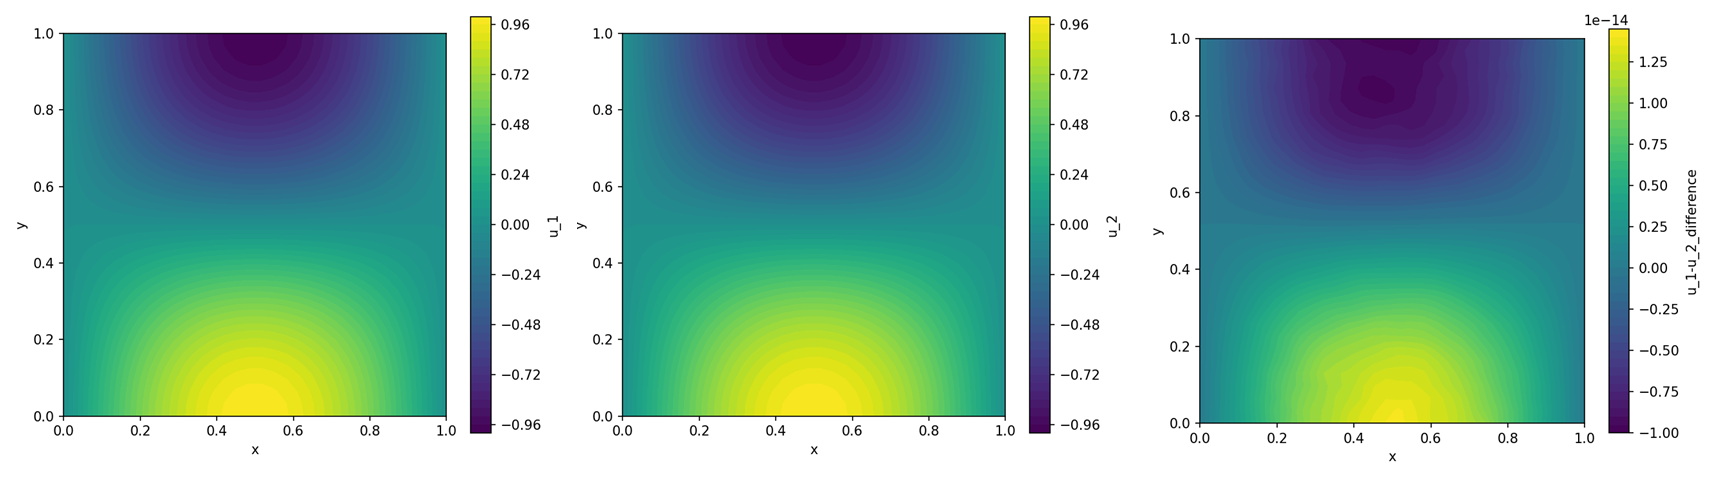

In [32]:
Image('32x32.png')

Figure 1: Comparison of two numerical solutions and their difference on the unit square with a 32x32 mesh. a) solution u_1 b) solution u_2 c) pointwise difference u_1 - u_2. Both solutions exhibit the same spatial structure and amplitude  and the differnce is at machine level precision, indicating the two methods provide virtually identical results

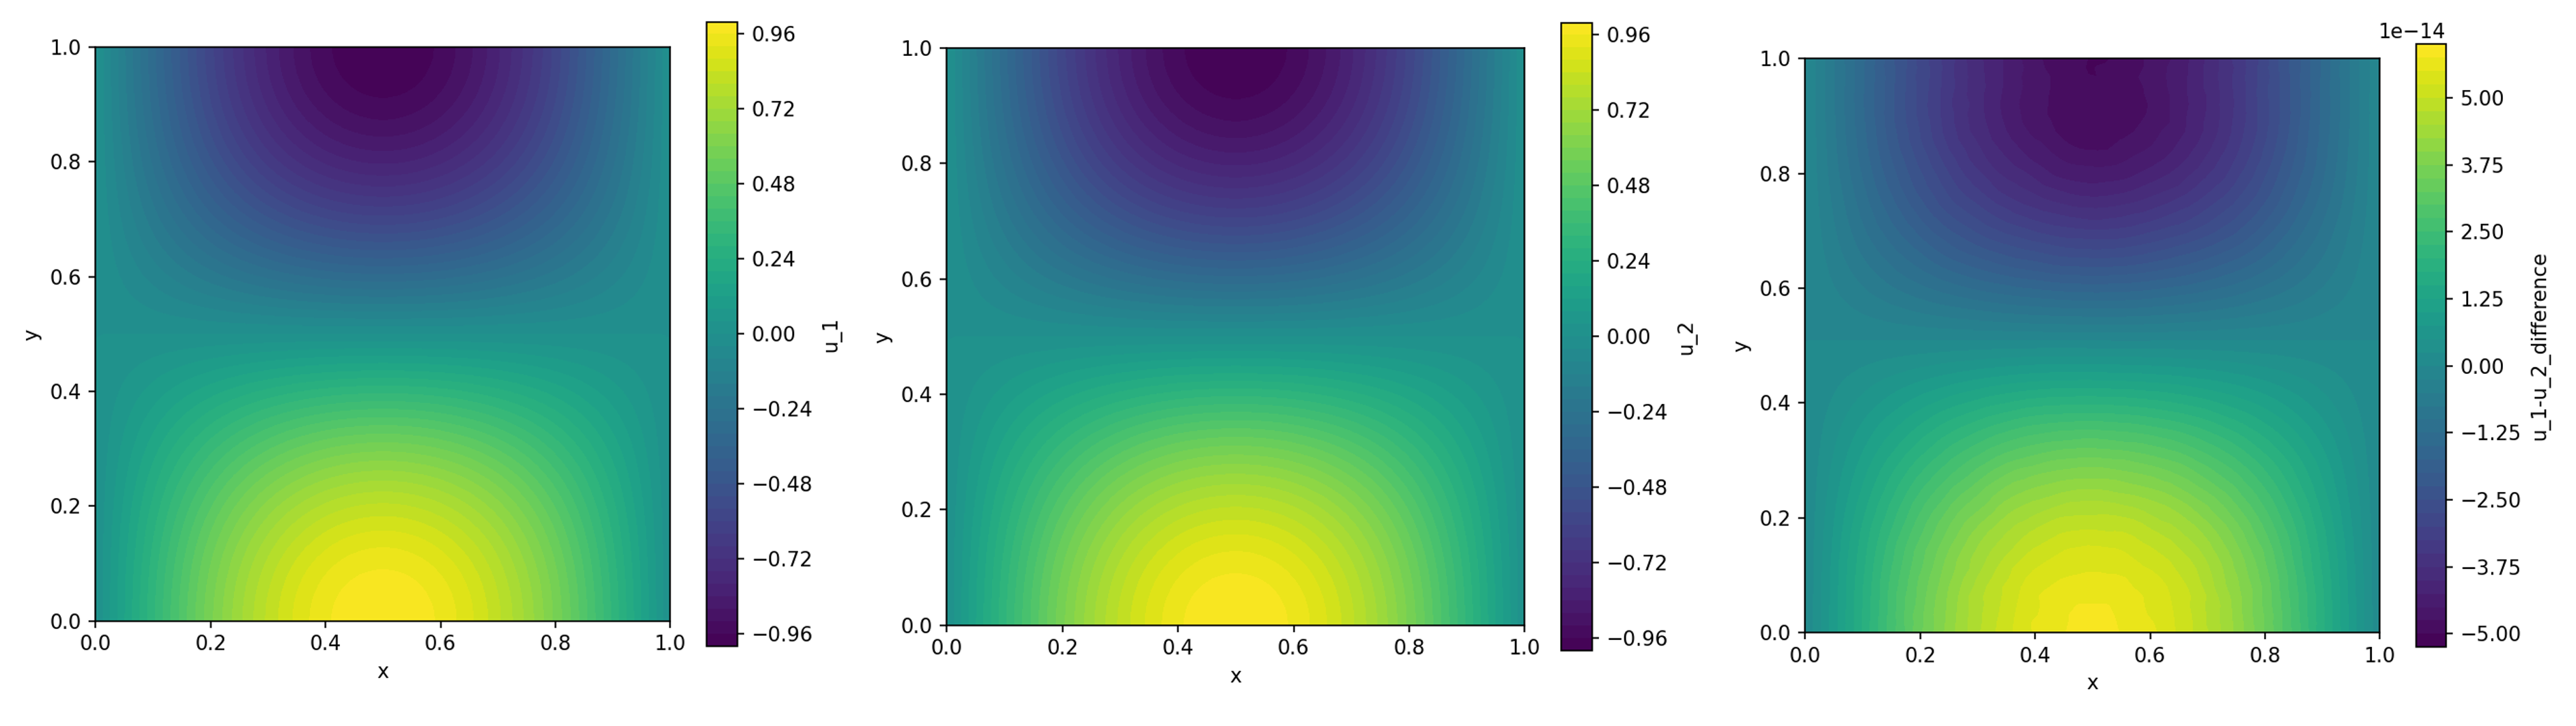

In [34]:
Image('64x64.png')

Figure 2: Comparison of two numerical solutions and their difference on the unit square with a 64x64 mesh. a) solution u_1 b) solution u_2 c) pointwise difference u_1 - u_2. Both solutions exhibit the same spatial structure and amplitude  and the differnce is at machine level precision, indicating the two methods provide virtually identical results

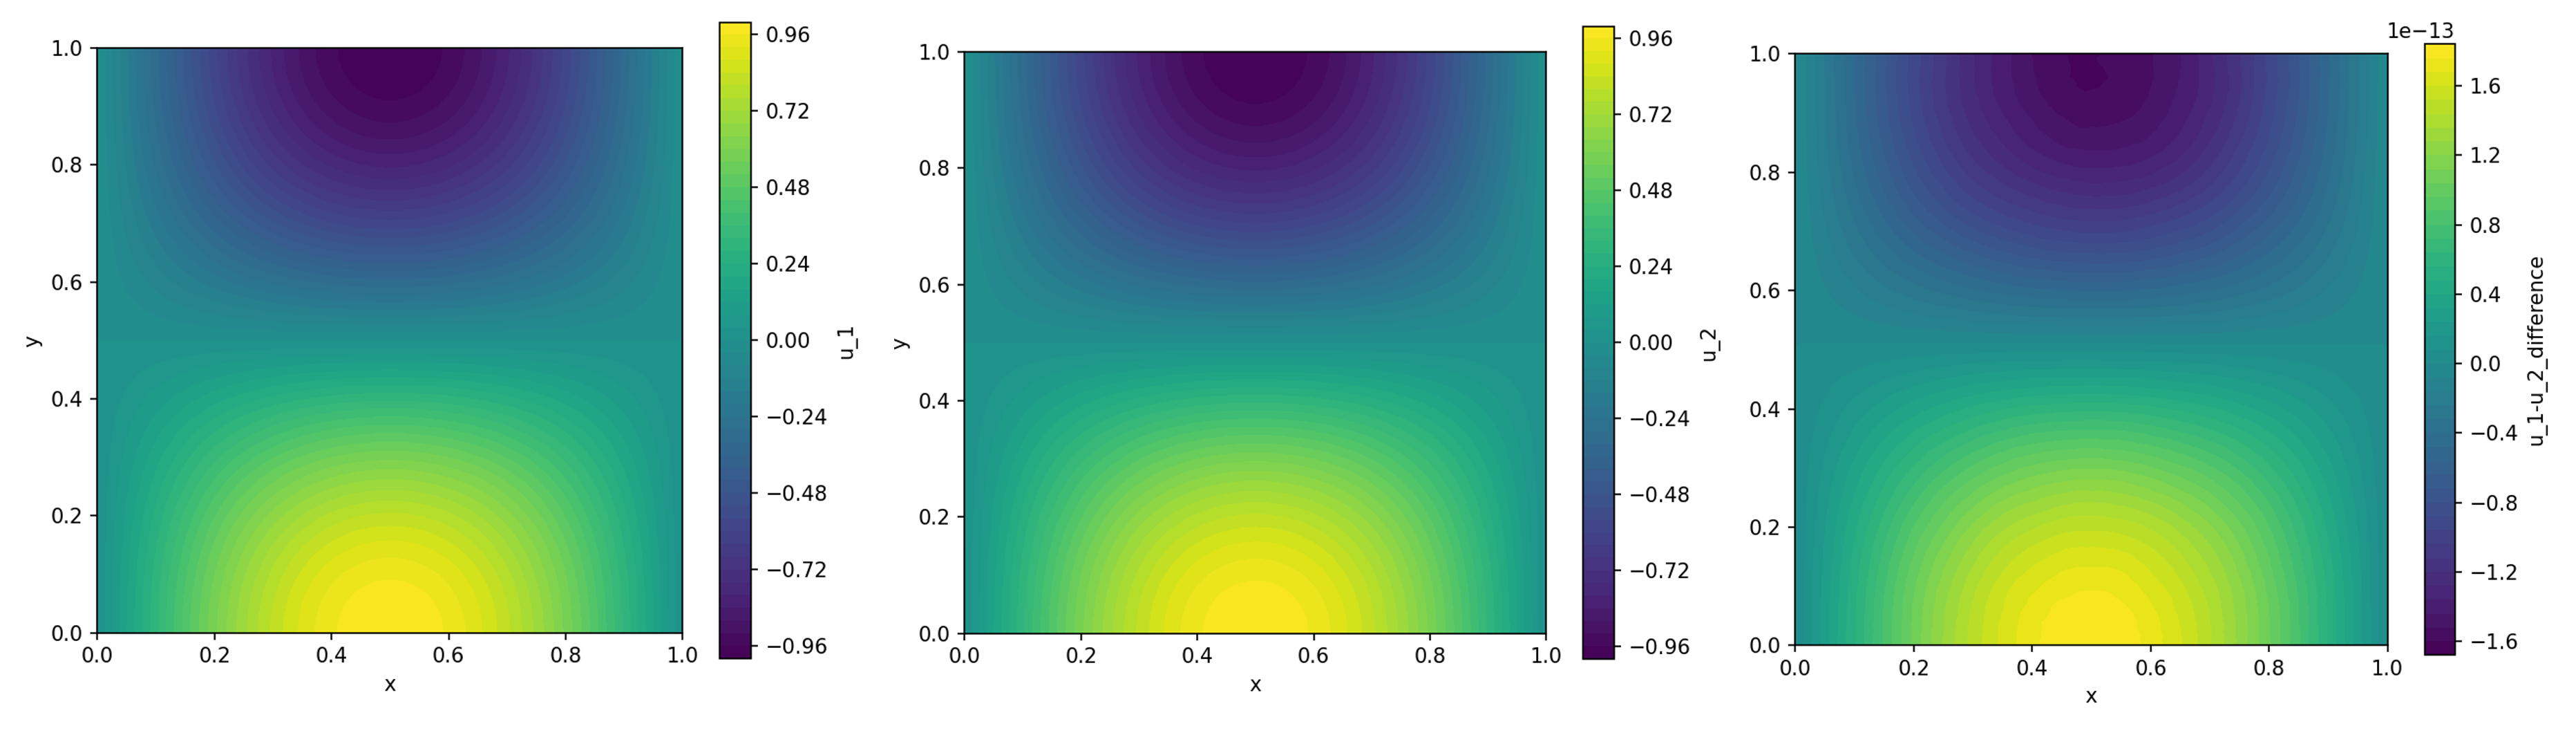

In [35]:
Image('128x128.png')

Figure 3: Comparison of two numerical solutions and their difference on the unit square with a 128 x 128 mesh. a) solution u_1 b) solution u_2 c) pointwise difference u_1 - u_2. Both solutions exhibit the same spatial structure and amplitude  and the differnce is at machine level precision, indicating the two methods provide virtually identical results

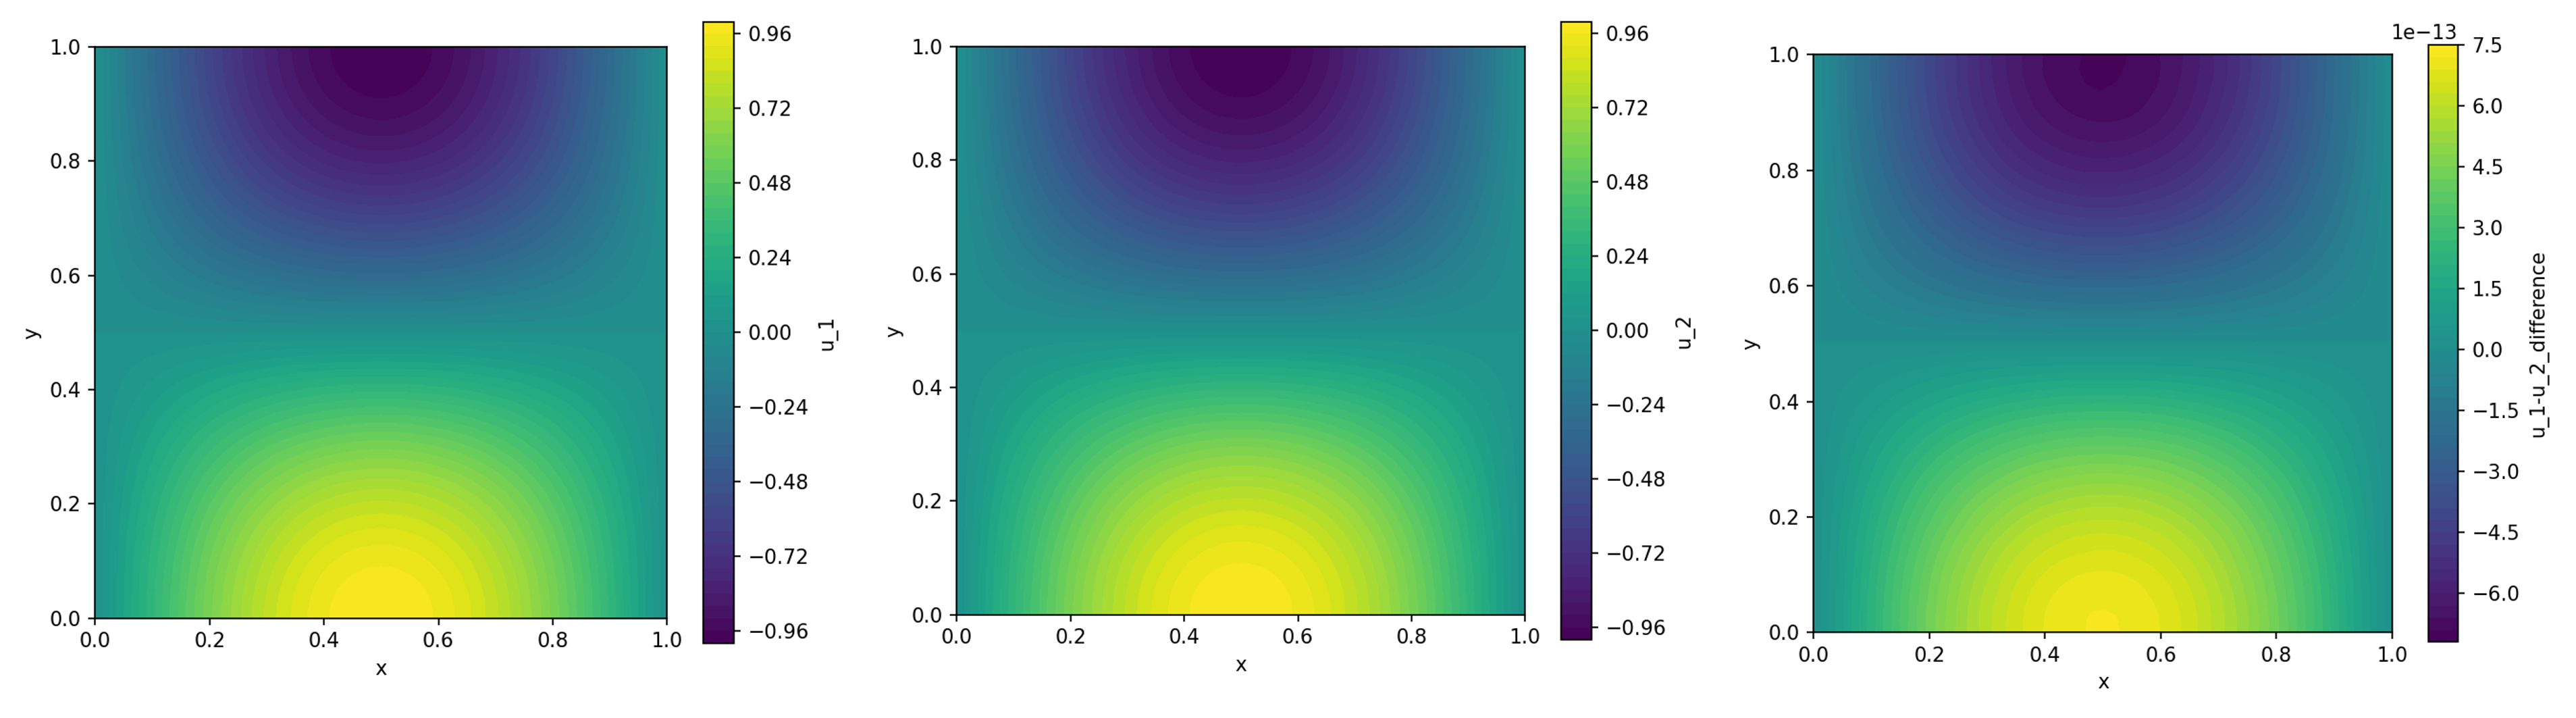

In [36]:
Image('256x256.png')

Figure 4: Comparison of two numerical solutions and their difference on the unit square with a 256 x 256 mesh. a) solution u_1 b) solution u_2 c) pointwise difference u_1 - u_2. Both solutions exhibit the same spatial structure and amplitude  and the differnce is at machine level precision, indicating the two methods provide virtually identical results

u_1: Explicit weak forumulations

u_2: Variation principle to find weak formulations which are then solved

The codes uses a continuous piecewise-linear finite element space for both methods. For smooth solutions we would expect $L^2$ errors to scale like $h^2$ for P1 elements; the observed $10^{-14}$ - $10^{-15}$ difference between the two methods is close to that of the floating point arithmetic accuracy. Then if double precision is used, it doesn't matter whether method u_1 or u_2 is used.

# ii) Exploring {h,p} pairs

As well as changing the mesh refinement (h), the order of accuracy can also be investigated (p) as to consider different pairs of values together


In [ ]:
nxs = [4*2**i for i in range(0,8)]  # Mesh resolutions to try: 16,32,64,128,256, 512
print(nxs)
orders = [1,2,3,4] # Polynomial orders to try

results = {}
for nx in nxs:
    ny = nx
    h=1/nx
    mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
    # Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
    x, y = SpatialCoordinate(mesh) # Mesh coordinates

    for p in orders:
        pair = (h, p)
        V = FunctionSpace(mesh, 'CG', p) # Piecewise continuous Galerkin function space of polynomials


        f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)


        bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed
        bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed

        # Defining functions
        v = TestFunction(V)
        u_h = Function(V, name='u_h') # Name of solution for first method
        u_exact = Function(V, name='u_exact').interpolate(sin(pi*x)*cos(pi*y))

        Ju = (0.5*inner(grad(u_h),grad(u_h)) - u_h*f)*dx # f->ULF? Step 2

        F = derivative(Ju, u_h, du=v) # Step 2/3: The weak form generated

        solve(F == 0, u_h, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2

        f.interpolate(sin(pi*x)*cos(pi*y))
        #L2_h = sqrt(assemble(dot(u_h - f, u_h - f) * dx)) # L2 error solution u1
        L2 = sqrt(assemble(dot(u_h - u_exact, u_h - u_exact) * dx)) # L2 error difference
        results[pair] = {"L2_diff": L2}
print(results)

[4, 8, 16, 32, 64, 128, 256, 512]


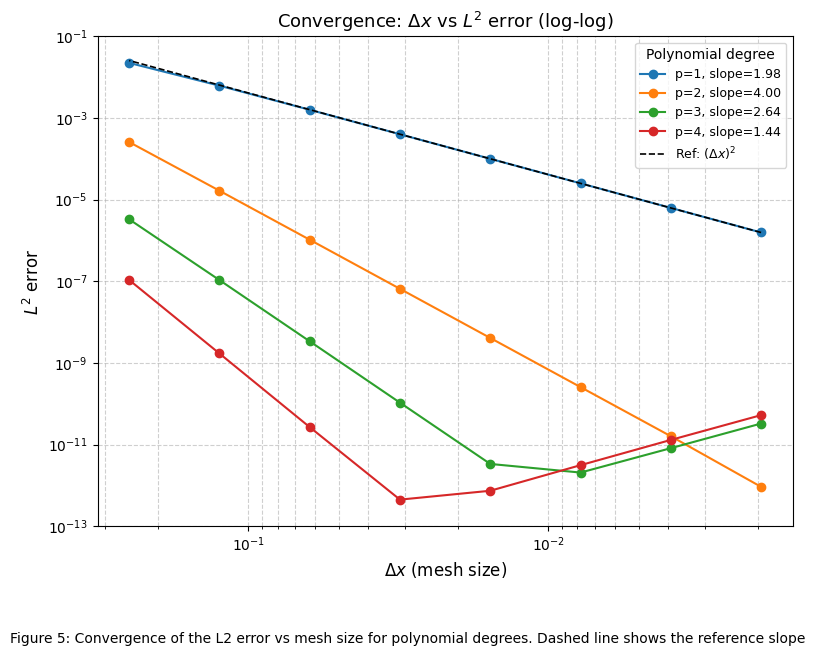

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

data = {
 (0.25, 1): {'L2_diff': 0.0224595527532744}, (0.25, 2): {'L2_diff': 0.0002581266490531602},
 (0.25, 3): {'L2_diff': 3.3026055722837436e-06}, (0.25, 4): {'L2_diff': 1.0780289692193855e-07},
 (0.125, 1): {'L2_diff': 0.006213900940246078}, (0.125, 2): {'L2_diff': 1.6573873959018296e-05},
 (0.125, 3): {'L2_diff': 1.0702295304430984e-07}, (0.125, 4): {'L2_diff': 1.7018159698815217e-09},
 (0.0625, 1): {'L2_diff': 0.0015930107731052336}, (0.0625, 2): {'L2_diff': 1.0427252512841122e-06},
 (0.0625, 3): {'L2_diff': 3.3787660909160757e-09}, (0.0625, 4): {'L2_diff': 2.6666290965120015e-11},
 (0.03125, 1): {'L2_diff': 0.0004007573364780158}, (0.03125, 2): {'L2_diff': 6.527728863221749e-08},
 (0.03125, 3): {'L2_diff': 1.0585764821639784e-10}, (0.03125, 4): {'L2_diff': 4.458866878207716e-13},
 (0.015625, 1): {'L2_diff': 0.0001003464040510207}, (0.015625, 2): {'L2_diff': 4.081519133427896e-09},
 (0.015625, 3): {'L2_diff': 3.340280659409523e-12}, (0.015625, 4): {'L2_diff': 7.356084889470874e-13},
 (0.0078125, 1): {'L2_diff': 2.5096426356809695e-05}, (0.0078125, 2): {'L2_diff': 2.551360140460445e-10},
 (0.0078125, 3): {'L2_diff': 2.053909956294726e-12}, (0.0078125, 4): {'L2_diff': 3.1170847427996713e-12},
 (0.00390625, 1): {'L2_diff': 6.274721514813019e-06}, (0.00390625, 2): {'L2_diff': 1.596705555781402e-11},
 (0.00390625, 3): {'L2_diff': 8.135445257100489e-12}, (0.00390625, 4): {'L2_diff': 1.2953741095262796e-11},
 (0.001953125, 1): {'L2_diff': 1.568721682613654e-06}, (0.001953125, 2): {'L2_diff': 9.172772594559712e-13},
 (0.001953125, 3): {'L2_diff': 3.264487059248683e-11}, (0.001953125, 4): {'L2_diff': 5.245471946445818e-11}
}

# organize by polynomial degree
by_p = defaultdict(list)
for (h, p), vals in data.items():
    by_p[p].append((h, vals['L2_diff']))
for p in by_p:
    by_p[p] = sorted(by_p[p], key=lambda x: x[0])  # ascending h (coarse->fine)

# plotting
#plt.style.use('seaborn')   # remove or change if unavailable
fig, ax = plt.subplots(figsize=(8,6))

colors = {1: 'C0', 2: 'C1', 3: 'C2', 4: 'C3'}
markers = {1: 'o', 2: 's', 3: '^', 4: 'D'}
slopes = {}

for p, pairs in sorted(by_p.items()):
    hs = np.array([h for h, _ in pairs])
    errs = np.array([e for _, e in pairs])
    mask = errs > 0
    hs = hs[mask]; errs = errs[mask]
    if len(hs) < 2:
        continue
    # fit slope in log-log
    logh = np.log10(hs)
    loge = np.log10(errs)
    slope, intercept = np.polyfit(logh, loge, 1)
    slopes[p] = slope

    # plot on log-log
    ax.loglog(hs, errs, marker= 'o', color=colors.get(p,'k'),
              linestyle='-', label=f'p={p}, slope={slope:.2f}')

# --- add a single dashed reference line proportional to (delta x)^2 ---
# choose h_ref as sorted unique h values
h_ref = np.array(sorted({h for (h, _) in data.keys()}))
# scale the reference line to sit near the p=1 curve: use the first available p=1 data point
p_ref = 1
if p_ref in by_p and len(by_p[p_ref])>0:
    h0, e0 = by_p[p_ref][0]   # first (coarsest) point for p=1
    ref = e0 * (h_ref / h0)**2
    ax.loglog(h_ref, ref, 'k--', linewidth=1.2, label=r'Ref: $(\Delta x)^2$')

# reverse x axis so coarse -> fine left->right
ax.invert_xaxis()

ax.set_xlabel(r'$\Delta x$ (mesh size)', fontsize=12)
ax.set_ylabel(r'$L^2$ error', fontsize=12)
ax.set_ylim(1e-13, 1e-1)
ax.set_title(r'Convergence: $\Delta x$ vs $L^2$ error (log-log)', fontsize=13)
ax.legend(title='Polynomial degree', fontsize=9)
ax.grid(True, which='both', ls='--', alpha=0.6)


caption = ("Figure 5: Convergence of the L2 error vs mesh size for polynomial degrees. Dashed line shows the reference slope")
fig.text(0.5, -0.08, caption, ha = 'center', fontsize = 10)


plt.tight_layout()
plt.show()


Figure 5 shows that each polynomial degree produces a monotonic decrease of $L^2$ error as $\Delta x$ decreases, showing convergence under refinement. The slopes of the log-log plot indicate a faster decay for larger p. For p= 3,4 the error initially decreases but then increases. This is because the $L_2$ error is made up of the discretisation error (h) and the algebraic error (p). The discretisation error decreases with decreasing h up to machine precision at $10^{-16}$. As the order p increases there are more terms added for each element so the algebraic error increases causing $L^2$ error increases. For more refined meshes there are more algebraic operations and so the error grows faster than the discretisation error. Hence theoretical equivalence is not equal to the pratical equivalence due to algebraic error


### iii) Explain and show which {h,p} combinations are roughly equivalent and why?







For p = 1 then as h decreases by a factor of 2, $L^2$ decreases by a factor of 4. Similarily for p = 2 as h decreases by a factor of 2, $L^2$ decreases by 16. When considering mesh refinement instead we come across similar relations. For h= 1/16 as p increases then $L^2$ decreases by 256 ($16^2$). Again similarily for h = 1/32 as p increases, $L^2$ decreases by 1024 ($32^2$).

To generalise these relations we consider {$h_p, p$} , {$h_q, q$} such that p< q and their L^2 errors are approximately equal:

  $L^2$ {$h_p,p$} = $O(h_p^p)$ = $L^2$ {$h_q,q$} = $O(h_q^q)$

  This gives

$L^2$({$h_p * 2^{-q/p}$,$ p$} = $O(h_p^p * 2^{-pq/p})$ = $O(h_p^p)$

and,

$L^2$({$h_q * 2^{-1}$,$ q$} = $O((h_q * 2^{-1})^q)$ = $O(h_q^q *2 ^{-q}) = O(h_2^q)$   .

Which means that $h_p$ must be halved $q/p$ times to achieve the same effect as halving $h_q$ once. Therefore the equivalent pairs are given by:

{$h_1 , 1$} =  {$h_2 , 2$} = {$h_4 , 4$}

$h_4 / 2 = h_2 / 4 =  h_1 / 8$





## 5. Explain how the first four steps are implemented in Firedrake by adding clear comments to the code

In [ ]:
#
# Solution by Firedrake FEM-CG of a Poisson equatiom
#
from firedrake import *


## 1. Mesh Generation ######################################################################################################

#Number of elements in the x and y directions

nx = ny = 256 # Try various mesh resolutions, starting coarse, say 16x16 etc.


mesh = UnitSquareMesh(nx,ny,quadrilateral=True) # Creates a structured quadrilateral mesh on unit square [0,1] x [0, 1]



##############################################################################################################################


## 2. Function Space Definition ##################################################################################################

# Define piecewise linear continuos GalerKin function space (CG1) so polynomials of degree 1 are continuous across element boundaries


V = FunctionSpace(mesh, 'CG', 1) # Piecewise linear continuous Galerkin function space or polynomials


# Discretisation used for all functions within the space V.
# For some function h defined on the unit square that is smooth and continuos, there exists some mapping to a function h_h in V such that this approximates h within a number of linear functions in each element of the mesh.

#################################################################################################################################

## 3. Method 1: Weak form manual construction ###################################################################################



#Define trial function and test function from the function space V.

u = TrialFunction(V) # The unknown or variable u(x,y) to be solved for
v = TestFunction(V)  # The testfunction of u

# Use mesh coordinates to define source term

x, y = SpatialCoordinate(mesh) # Mesh coordinates


#Source term from the function space V
f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y) so the exact solution is u(x,y) = sin(\pi x) cos(\pi y)

# Bilinear form:
a = (inner(grad(u),grad(v)))*dx # LHS of the weak form

#Linear form:
L = (f*v)*dx # RHS of the weak form were dx = dxdy - infinitesimal area element



u_1 = Function(V, name='u_1') # Function for the solution from Method 1

## Dirichlet Boundary conditions

bc_x0 = DirichletBC(V, Constant(0), 1) # u = 0 on boundary at x=0
bc_x1 = DirichletBC(V, Constant(0), 2) # u = 0 on boundary at x=1

#Solve the linear system subject to boundary conditions with solve parameters: Conjugate gradient iterative solver, no preconditioner

solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0,bc_x1])


##################################################################################################################################################

## 4.  Method 2: Variational Principle via Derivative ##############################################################################################


#This method defines the Ritz-Galerkin function, then minimizes and takes the first derivative with respect to u to give weak form.
#Finding minimal point of J[u] by finding where the derivative is 0 numerically given the derivative is v



u_2 = Function(V, name='u_2') # solution function for Method 2

Ju = (0.5*inner(grad(u_2),grad(u_2)) - u_2*f)*dx # Define Ritz Galerkin function J[u] so that minimiser of J[u] satifies -del^2 u = f


#Compute the first variation of J wrt u_2 in the direction of test function v which then generates the weak form F(u,v) = 0

F = derivative(Ju, u_2, du=v)


# Solve the nonlinear system F(u,v) = 0 subject to boundary conditions

solve(F == 0, u_2, bcs=[bc_x0, bc_x1])


########################################################################################################################################################


## 5.  Post-processing ###################################################################################################################################


# Write solutions to ParaView - compatible VTK file for visualisation

outfile = VTKFile('output.pvd')
outfile.write(u_1, u_2)

#Compute L2 errors by comparing with exact solution including difference between two methods


f.interpolate(sin(pi*x)*cos(pi*y))
L2_1 = sqrt(assemble(dot(u_1 - f, u_1 - f) * dx)) # L2 error solution u1
L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx)) # L2 error solution u2
L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx)) # L2 error difference

#Print results to console

print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
print(f'L2 norm between the two results: {L2}')




## 6. Change and implement the boundary conditions for a different function f(x,y) and exact solution u(x,y)

Consider the exact solution:  $u_{exact} (x,y) = sin (2 \pi x) sin(3\pi y)$

The laplacian gives $ \Delta u_{exact} = - ((2 \pi)^2 + (3 \pi)^2)  sin (2 \pi x) sin(3\pi y)  $ hence,   $f (x,y) =  - Δ u_{exact} =  ((2 \pi)^2 + (3 \pi)^2)  sin (2 \pi x) sin(3\pi y)  $


Impose the Dirichlet boundary conditions on the whole boundary so that it is smooth and nontrivial in both directions.



Rewritten and adapted code following from originally given firedrake code

Mesh resolution: Δx = 0.00390625
L2 error: Method1 = 4.681e-05, Method2 = 4.681e-05
L2 norm between the two results: 5.829e-14


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_1_contour.png
Saved contour plot to: u_2_contour.png


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Saved contour plot to: u_1-u_2_difference_contour.png


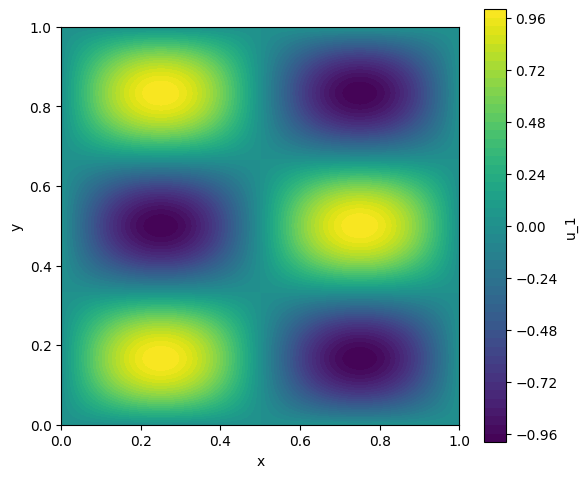

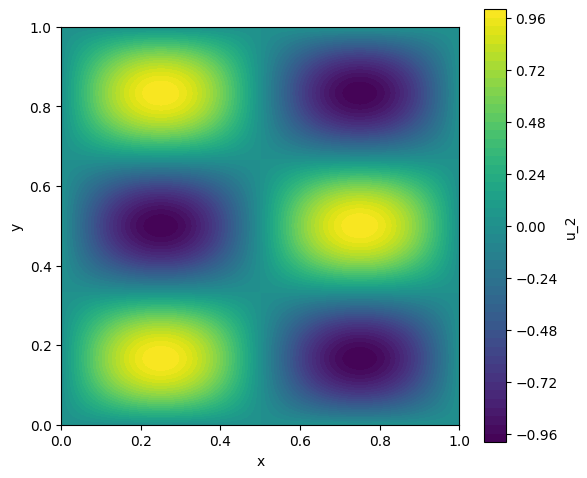

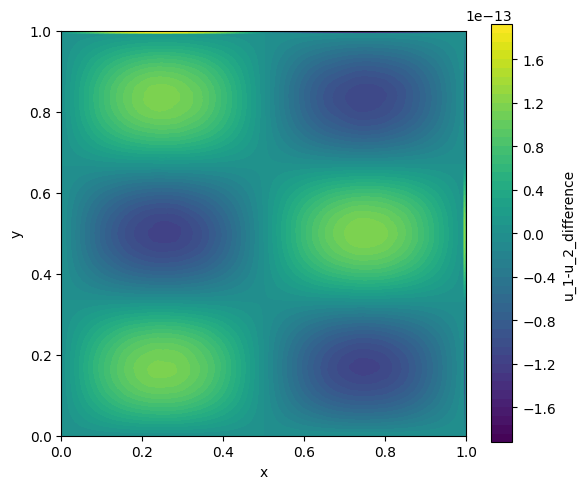

In [3]:
# --- replace the previous f and BC definitions with this block ---
x, y = SpatialCoordinate(mesh)

# exact solution (symbolic)
u_exact_sym = sin(2*pi*x) * sin(3*pi*y)

# compute f = -Delta u_exact symbolically
f_sym = -div(grad(u_exact_sym))

# interpolate f into V for use in the linear form
f = Function(V).interpolate(f_sym)

# Dirichlet BC from exact solution on the whole boundary
bc = DirichletBC(V, u_exact_sym, "on_boundary")

# assemble and solve (Method 1)
a = inner(grad(u), grad(v)) * dx
L = f * v * dx
u_1 = Function(V, name='u_1')
solve(a == L, u_1, bcs=[bc], solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'})

# Method 2 (variational derivative) — reuse f and bc
u_2 = Function(V, name='u_2')
Ju = (0.5*inner(grad(u_2), grad(u_2)) - u_2*f) * dx
F = derivative(Ju, u_2, du=v)
solve(F == 0, u_2, bcs=[bc])

# compute L2 errors against exact solution
u_exact_interp = Function(V).interpolate(u_exact_sym)
L2_1 = sqrt(assemble((u_1 - u_exact_interp)**2 * dx))
L2_2 = sqrt(assemble((u_2 - u_exact_interp)**2 * dx))
L2_diff = sqrt(assemble((u_2 - u_1)**2 * dx))

print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1:.3e}, Method2 = {L2_2:.3e}')
print(f'L2 norm between the two results: {L2_diff:.3e}')


import matplotlib.pyplot as plt

def contour_plot(x, y, f, name):
    # Create grid
    x = np.linspace(0.0, 1.0, nx)
    y = np.linspace(0.0, 1.0, ny)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Evaluate f on grid using Firedrake's f.at()
    for j in range(len(y)):
        for i in range(len(x)):
            xv = X[j, i]
            yv = Y[j, i]
            Z[j, i] = f.at([xv, yv], tolerance=1e-10)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    cbar = fig.colorbar(cs, ax=ax)
    cbar.set_label(name)

    fig.tight_layout()
    fig.savefig(name + '_contour.png', dpi=150)
    print("Saved contour plot to:", name + "_contour.png")


contour_plot(x, y, u_1, 'u_1')
contour_plot(x, y, u_2, 'u_2')

u_diff = Function(V, name='u_1_minus_u_2')
u_diff.interpolate(u_1 - u_2)

contour_plot(x, y, u_diff, 'u_1-u_2_difference')
